# Prediction Diabetes Using Classification Machine Learning Algorithms

# Business Problem

📌 It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

# Dataset Story

📌 The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

Pregnancies: Number of pregnancies

Glucose: 2-hour plasma glucose concentration in the oral glucose tolerance test

Blood Pressure: Blood Pressure (Small blood pressure) (mm Hg)

SkinThickness: Skin Thickness

Insulin: 2-hour serum insulin (mu U/ml)

DiabetesPedigreeFunction: Function (2 hour plasma glucose concentration in oral glucose tolerance test)

BMI: body mass index

Age: Age (years)

Outcome: Have the disease (1) or not (0)


# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
!pip install xgboost
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install missingno
import missingno as msno
import pickle

import warnings
warnings.simplefilter(action="ignore")

# Import Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# General Information About to the Dataset

In [ ]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

######################### Head #########################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.6000                    0.6270   50        1
1            1       85             66             29        0 26.6000                    0.3510   31        0
2            8      183             64              0        0 23.3000                    0.6720   32        1
3            1       89             66             23       94 28.1000                    0.1670   21        0
4            0      137             40             35      168 43.1000                    2.2880   33        1
######################### Tail #########################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.9000                    0.1710   63    

# Analysis of Categorical and Numerical Variables

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")

Observations: 768
Variables: 9
Cat_cols: 1
Num_cols: 8
Cat_but_car: 0


In [ ]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [ ]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

         Outcome  Ration
Outcome                 
0            500 65.1042
1            268 34.8958
##########################################


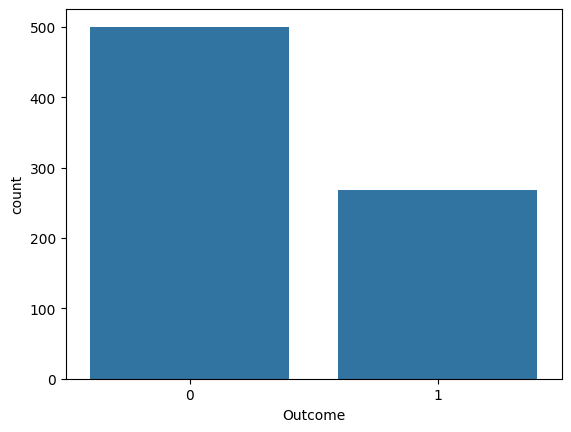

In [ ]:
cat_summary_df(df)

In [ ]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [ ]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   768.0000
mean      3.8451
std       3.3696
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       1.0000
30%       1.0000
40%       2.0000
50%       3.0000
60%       4.0000
70%       5.0000
80%       7.0000
90%       9.0000
95%      10.0000
99%      13.0000
max      17.0000
Name: Pregnancies, dtype: float64


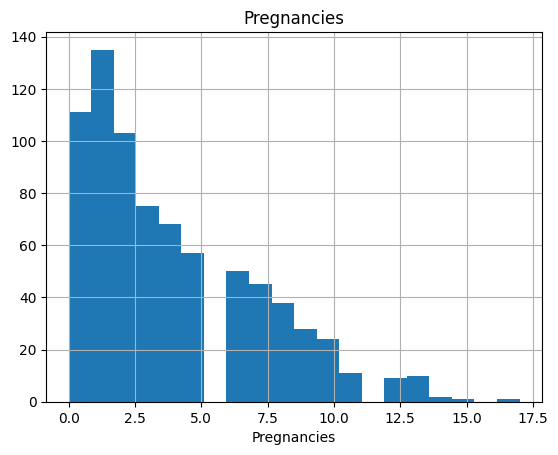

count   768.0000
mean    120.8945
std      31.9726
min       0.0000
1%       57.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
max     199.0000
Name: Glucose, dtype: float64


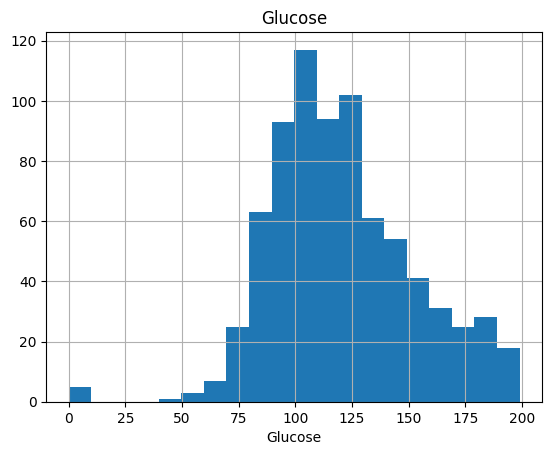

count   768.0000
mean     69.1055
std      19.3558
min       0.0000
1%        0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
max     122.0000
Name: BloodPressure, dtype: float64


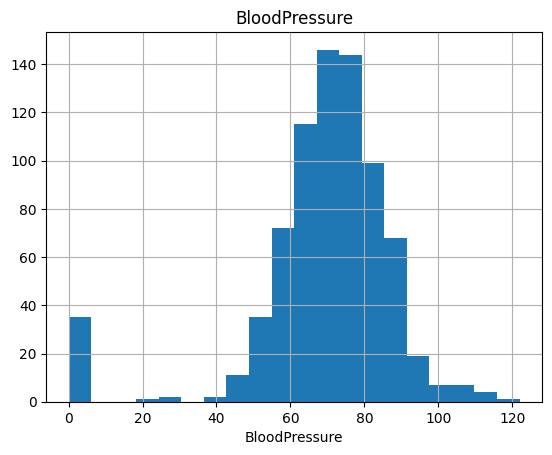

count   768.0000
mean     20.5365
std      15.9522
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
max      99.0000
Name: SkinThickness, dtype: float64


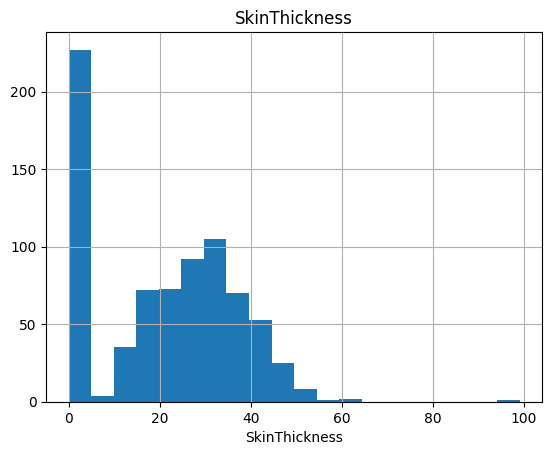

count   768.0000
mean     79.7995
std     115.2440
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
max     846.0000
Name: Insulin, dtype: float64


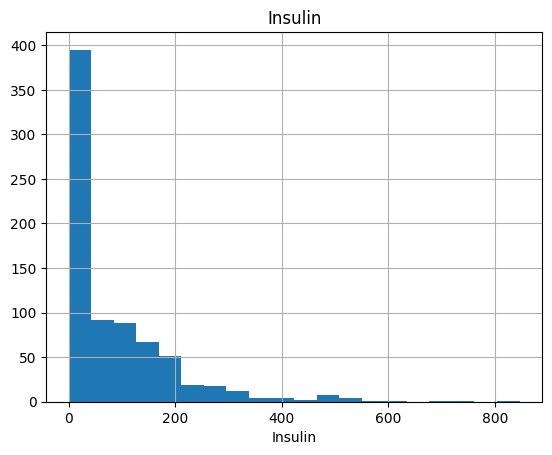

count   768.0000
mean     31.9926
std       7.8842
min       0.0000
1%        0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
max      67.1000
Name: BMI, dtype: float64


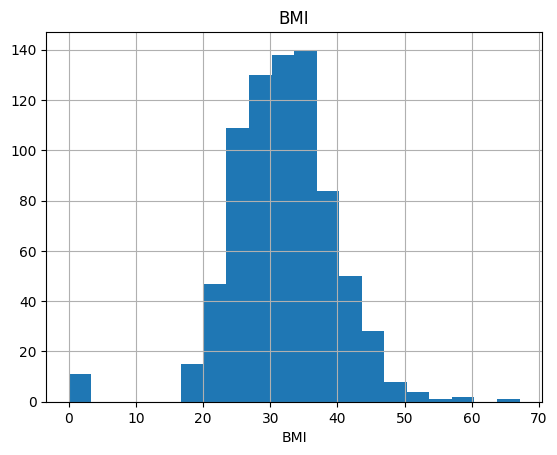

count   768.0000
mean      0.4719
std       0.3313
min       0.0780
1%        0.0947
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


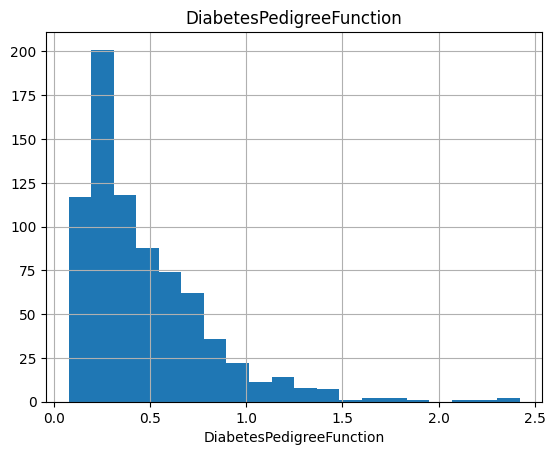

count   768.0000
mean     33.2409
std      11.7602
min      21.0000
1%       21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
max      81.0000
Name: Age, dtype: float64


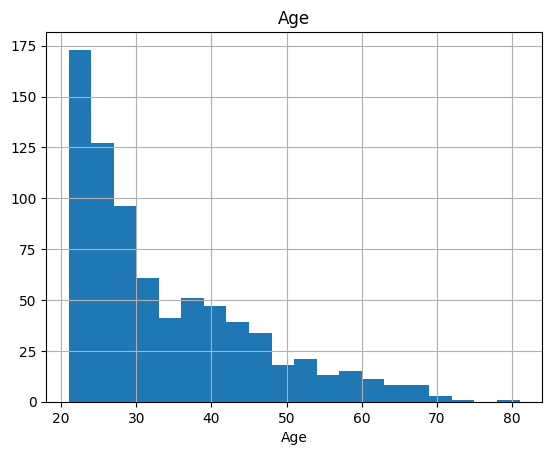

In [ ]:
num_summary_df(df)

In [ ]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  plt.figure(figsize=(12,4))
  for index, col in enumerate(num_cols):
    plt.subplot(2,4,index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

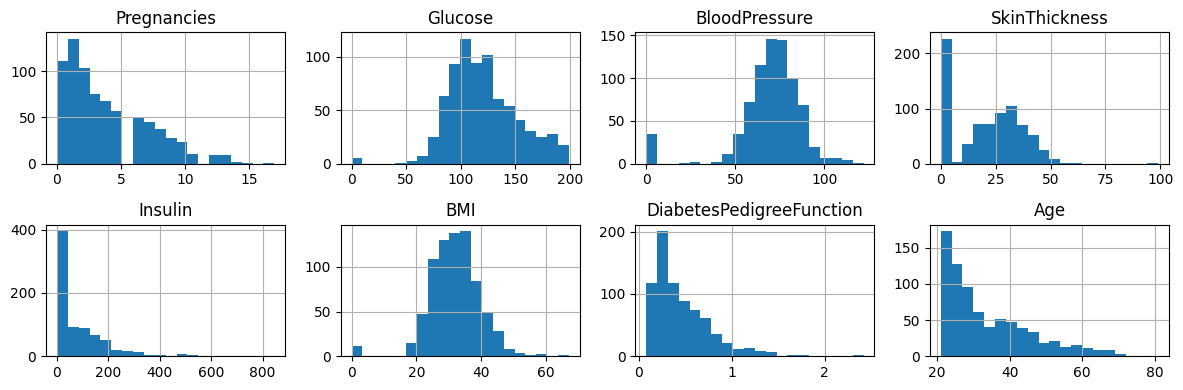

In [ ]:
plot_num_summary(df)

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("#############################################")

In [ ]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [ ]:
target_summary_with_num_df(df, "Outcome")

         Pregnancies
Outcome             
0             3.2980
1             4.8657
#############################################
         Glucose
Outcome         
0       109.9800
1       141.2575
#############################################
         BloodPressure
Outcome               
0              68.1840
1              70.8246
#############################################
         SkinThickness
Outcome               
0              19.6640
1              22.1642
#############################################
         Insulin
Outcome         
0        68.7920
1       100.3358
#############################################
            BMI
Outcome        
0       30.3042
1       35.1425
#############################################
         DiabetesPedigreeFunction
Outcome                          
0                          0.4297
1                          0.5505
#############################################
            Age
Outcome        
0       31.1900
1       37.0672
##########

# Correlation Analysis

In [ ]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.0000,0.1295,0.1413,-0.0817,-0.0735,0.0177,-0.0335,0.5443,0.2219
Glucose,0.1295,1.0000,0.1526,0.0573,0.3314,0.2211,0.1373,0.2635,0.4666
BloodPressure,0.1413,0.1526,1.0000,0.2074,0.0889,0.2818,0.0413,0.2395,0.0651
SkinThickness,-0.0817,0.0573,0.2074,1.0000,0.4368,0.3926,0.1839,-0.1140,0.0748
Insulin,-0.0735,0.3314,0.0889,0.4368,1.0000,0.1979,0.1851,-0.0422,0.1305
BMI,0.0177,0.2211,0.2818,0.3926,0.1979,1.0000,0.1406,0.0362,0.2927
DiabetesPedigreeFunction,-0.0335,0.1373,0.0413,0.1839,0.1851,0.1406,1.0000,0.0336,0.1738
Age,0.5443,0.2635,0.2395,-0.1140,-0.0422,0.0362,0.0336,1.0000,0.2384
Outcome,0.2219,0.4666,0.0651,0.0748,0.1305,0.2927,0.1738,0.2384,1.0000


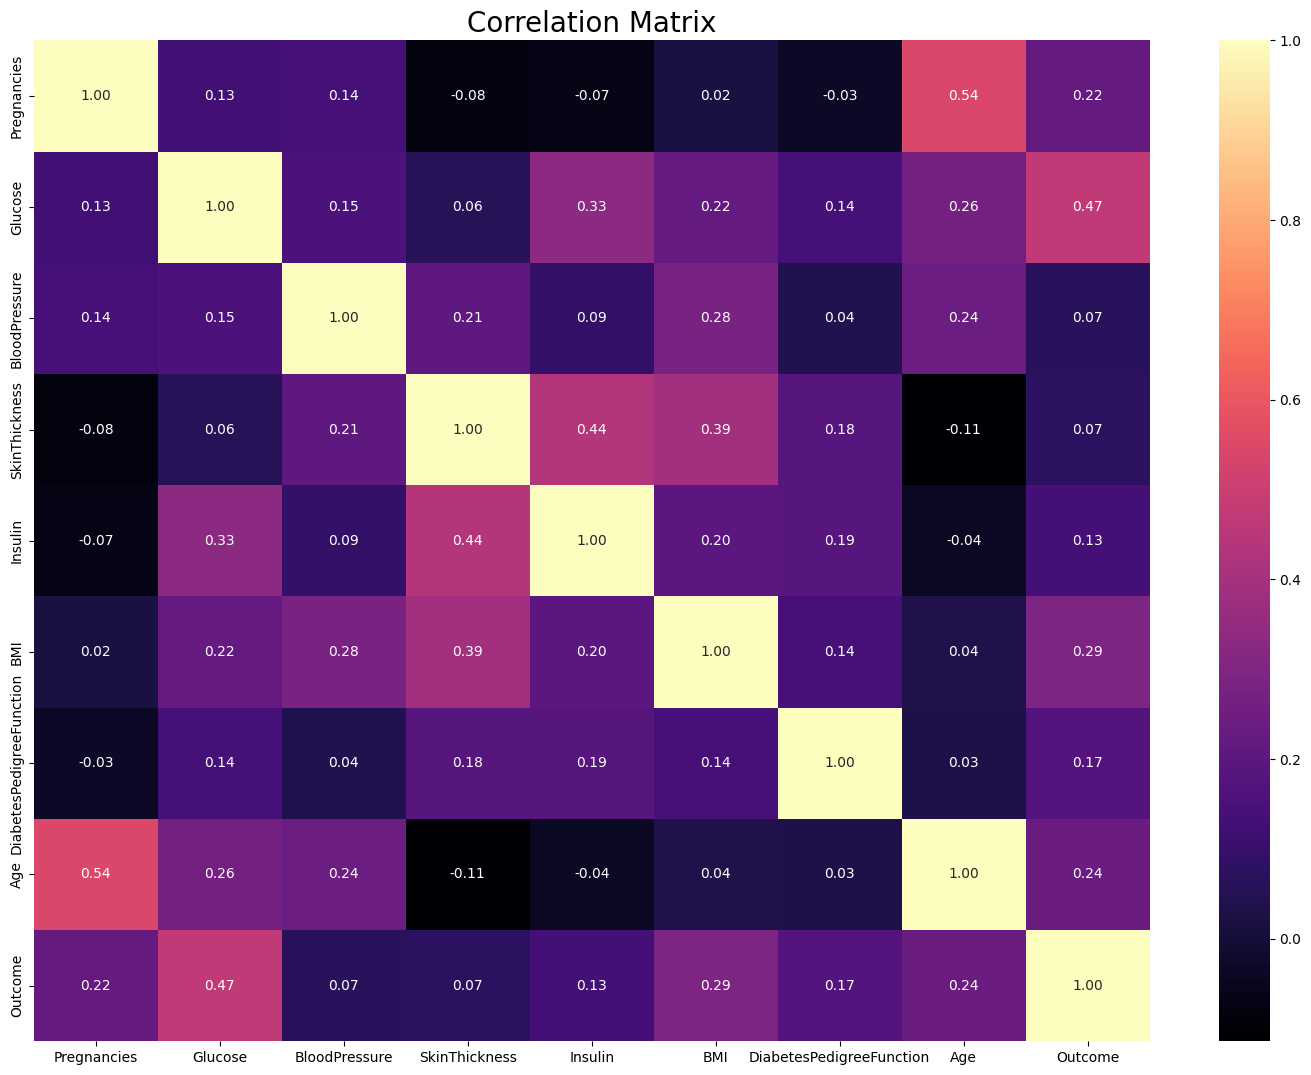

In [ ]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th = 0.90):
  corr = dataframe.corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

  if drop_list == []:
    print("############## After Correlation Analysis, You Don't Need to Remove Variables ##############")

  if plot:
    sns.set(rc = {'figure.figsize':(18,13)})
    sns.heatmap(corr, cmap="RdBu")
    plt.show()
  return drop_list

############## After Correlation Analysis, You Don't Need to Remove Variables ##############


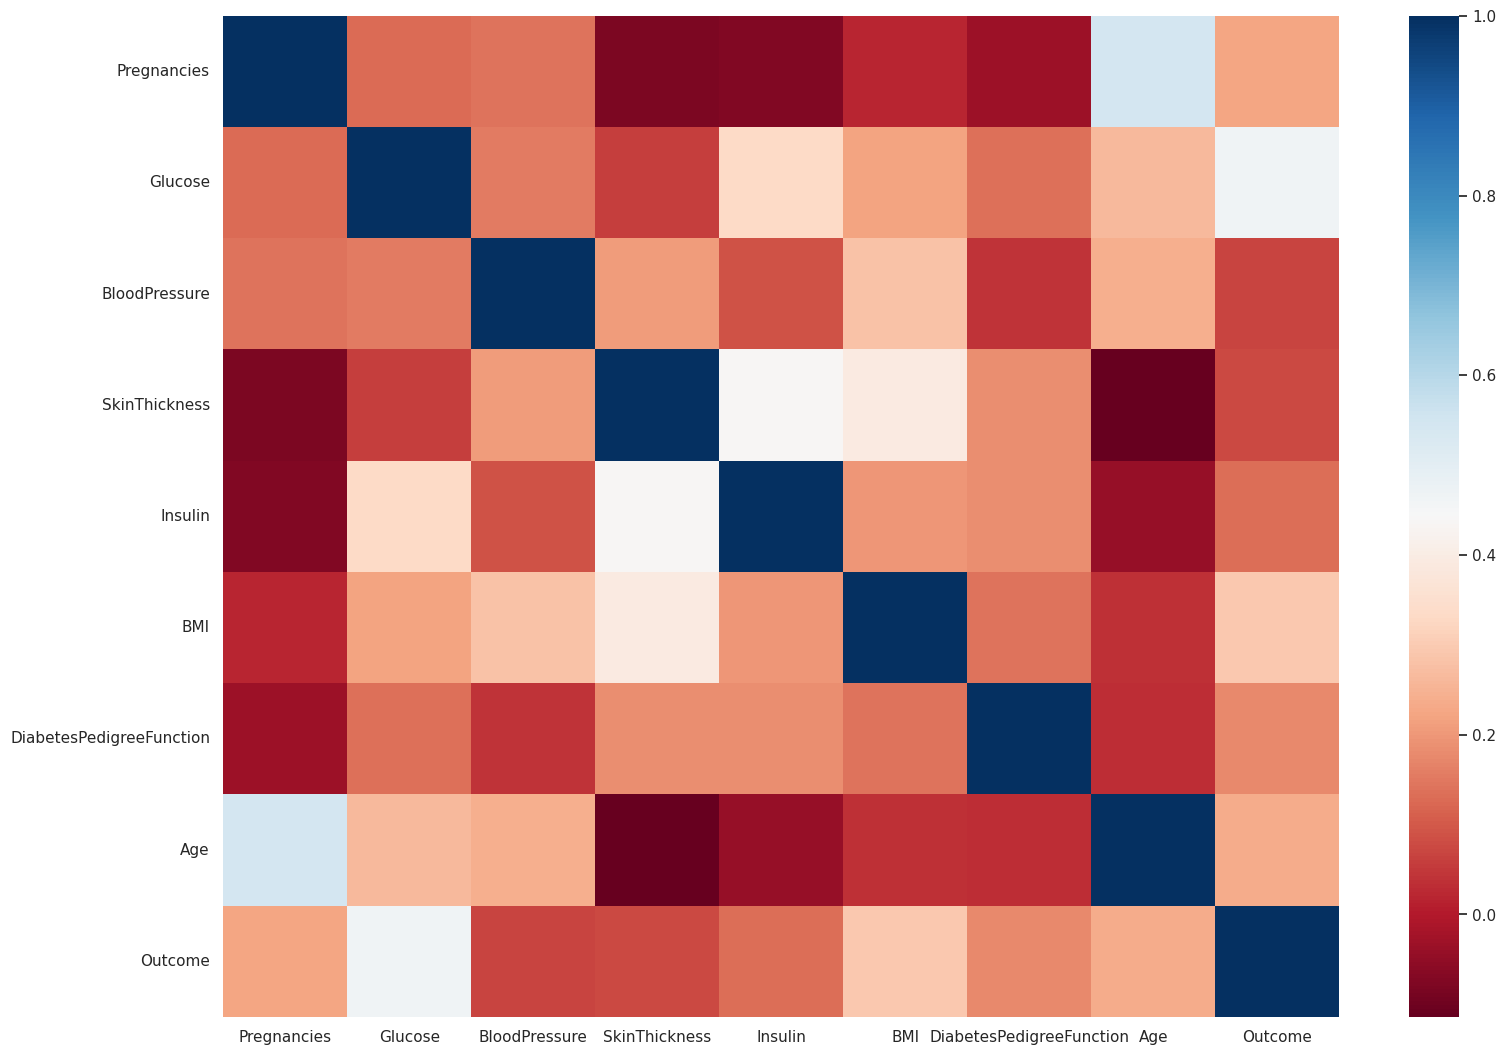

[]

In [ ]:
high_correlated_cols(df, plot=True)

# Create a distplot, boxplot, and probplot

In [ ]:
def exploratory_data(dataframe):
  import warnings
  warnings.filterwarnings('ignore')
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  fig,ax = plt.subplots(8,3,figsize=(30,90))
  for index, col in enumerate(num_cols):
    sns.distplot(dataframe[col],ax=ax[index,0])
    sns.boxplot(dataframe[col],ax=ax[index,1])
    stats.probplot(dataframe[col],plot=ax[index,2])
  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Visualizing Continuous Columns")

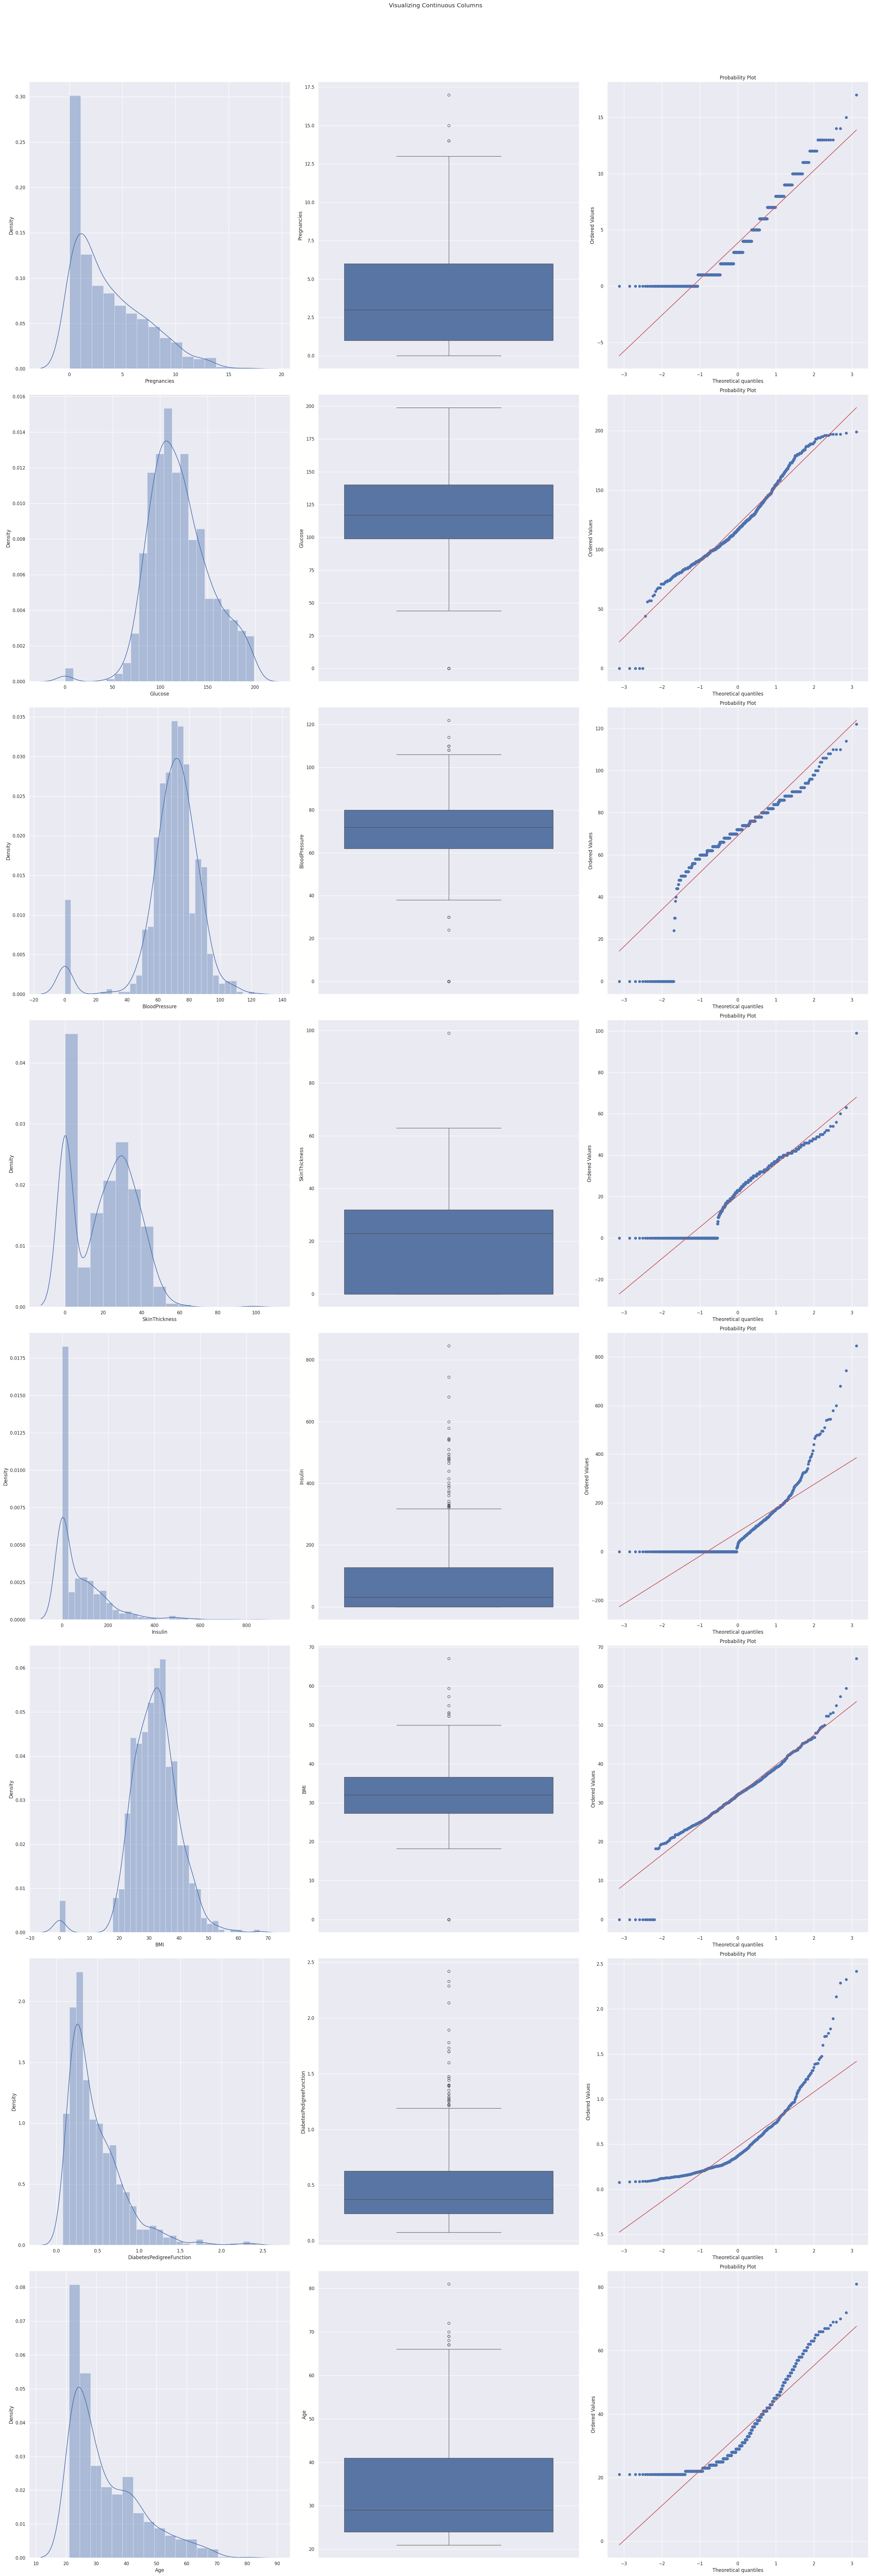

In [ ]:
exploratory_data(df)

# Missing Value Analysis

**Not:** It is known that a human cannot have variable values 0 other than Pregnancies and Outcome. Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [ ]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
def missing_value_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [ ]:
na_columns = missing_value_table(df, na_name=True)

               n_miss   ratio
Insulin           374 48.7000
SkinThickness     227 29.5600
BloodPressure      35  4.5600
BMI                11  1.4300
Glucose             5  0.6500


In [ ]:
def show_missing_value_plot(dataframe, bar=True, matrix=True, heatmap=True):
  if bar:
    msno.bar(dataframe);
  if matrix:
    msno.matrix(dataframe);
  if heatmap:
    msno.heatmap(dataframe);

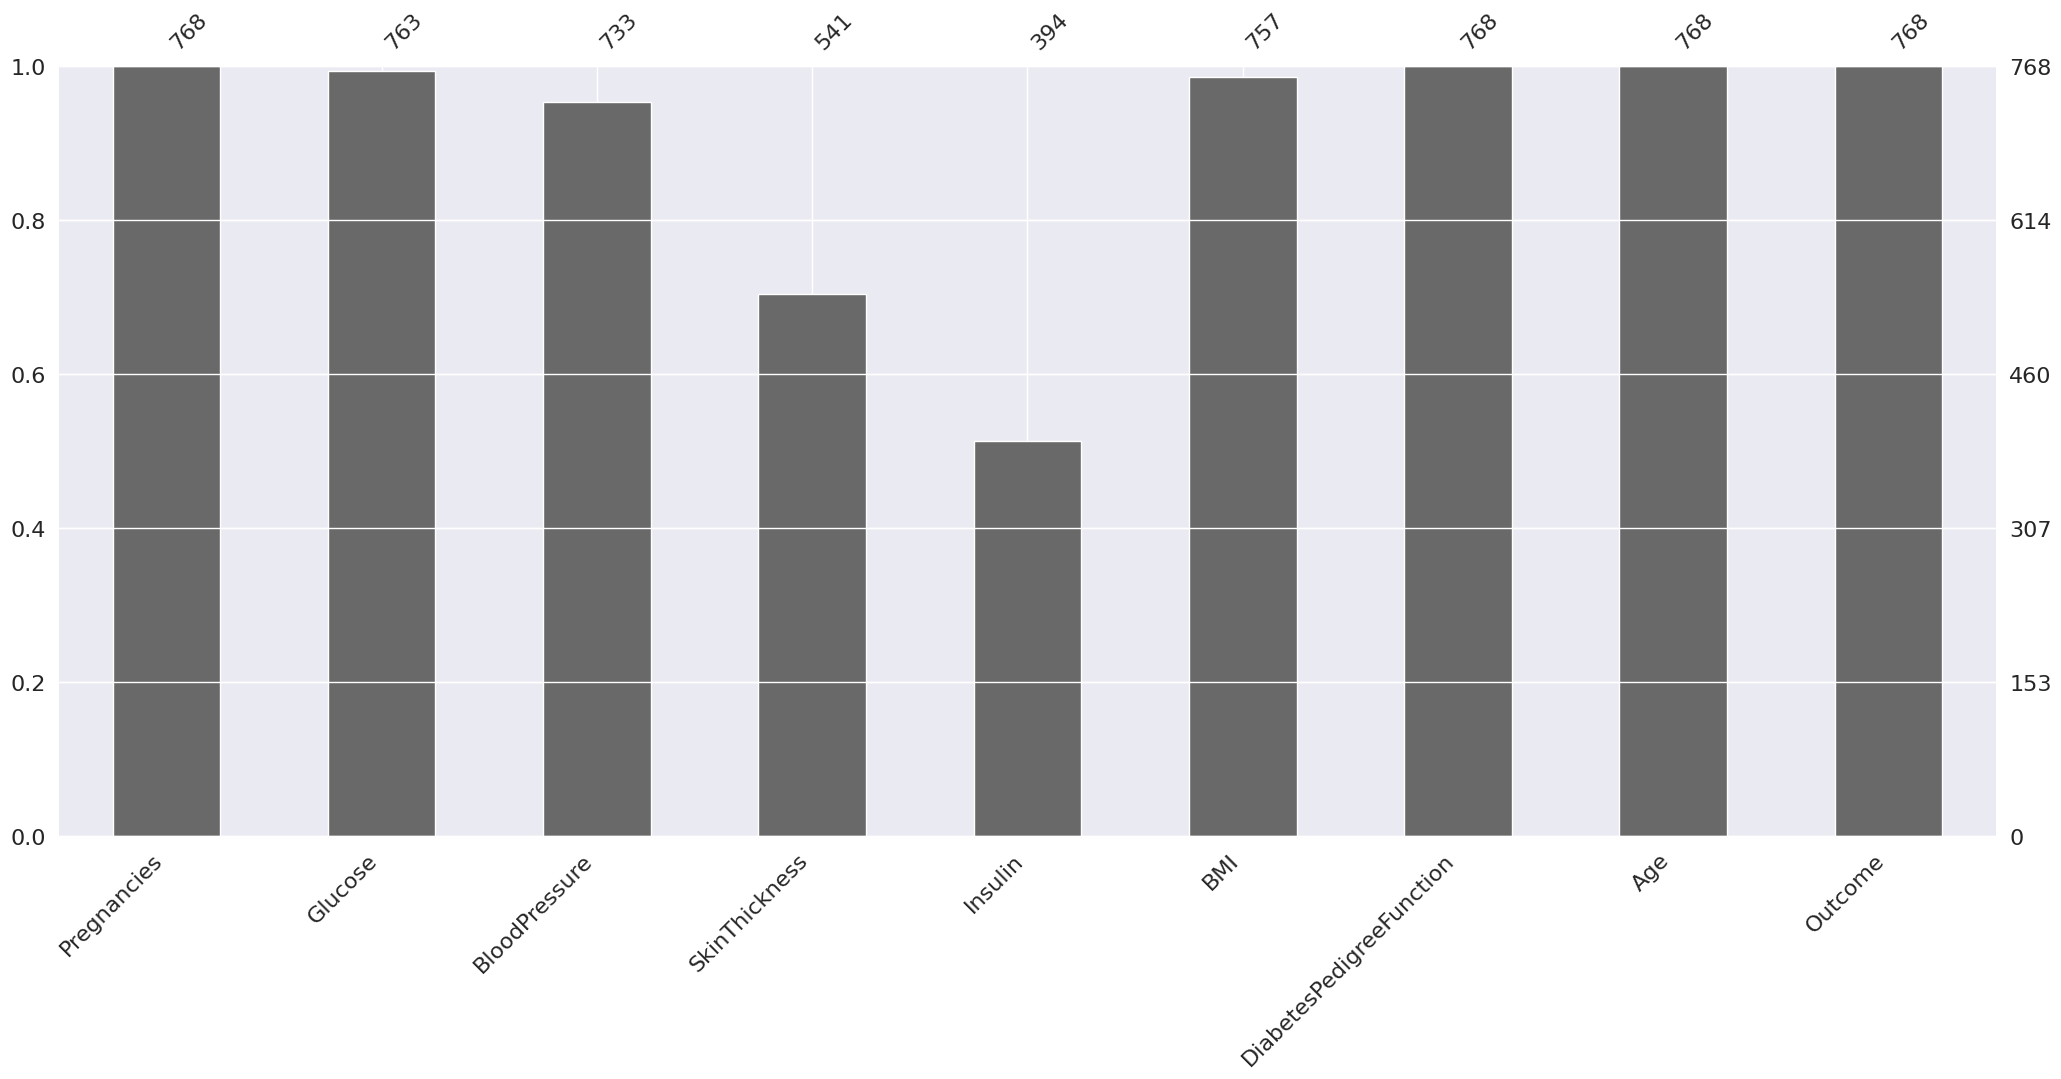

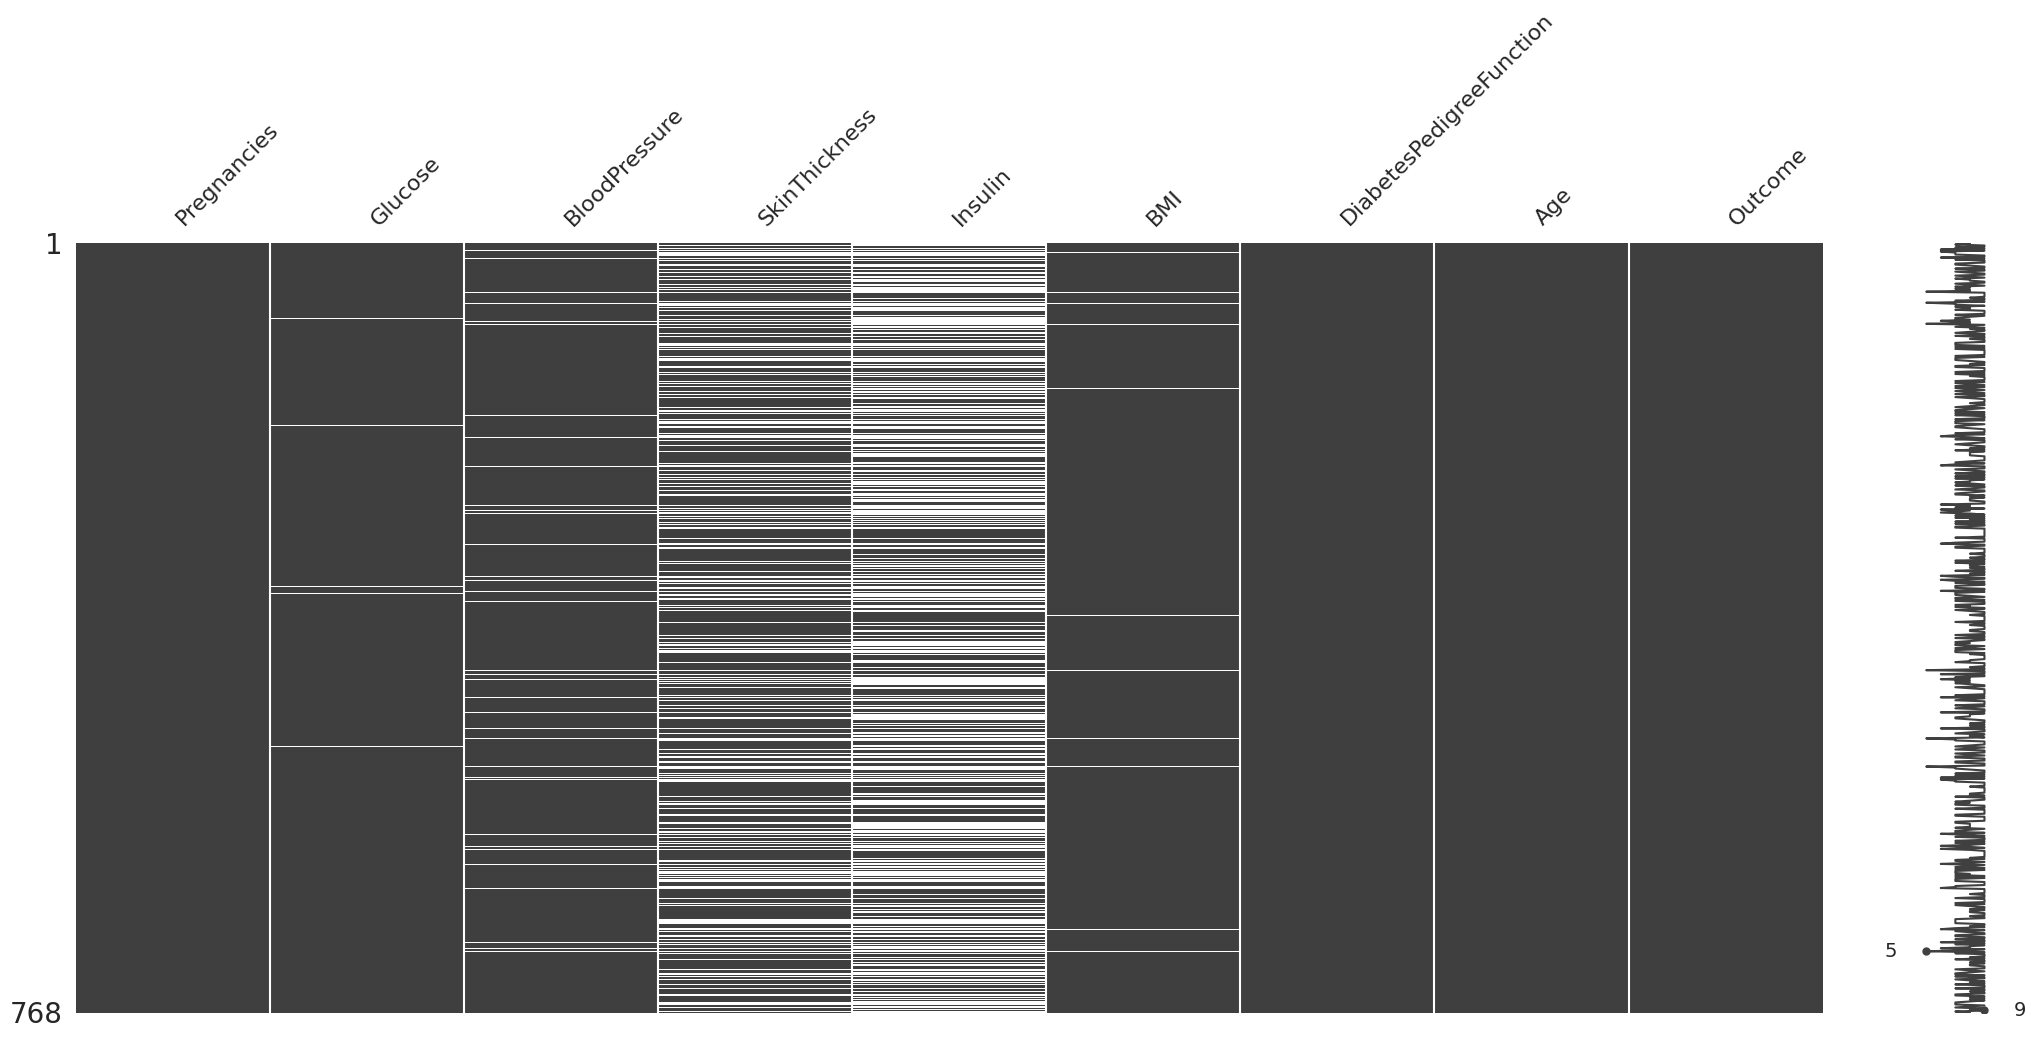

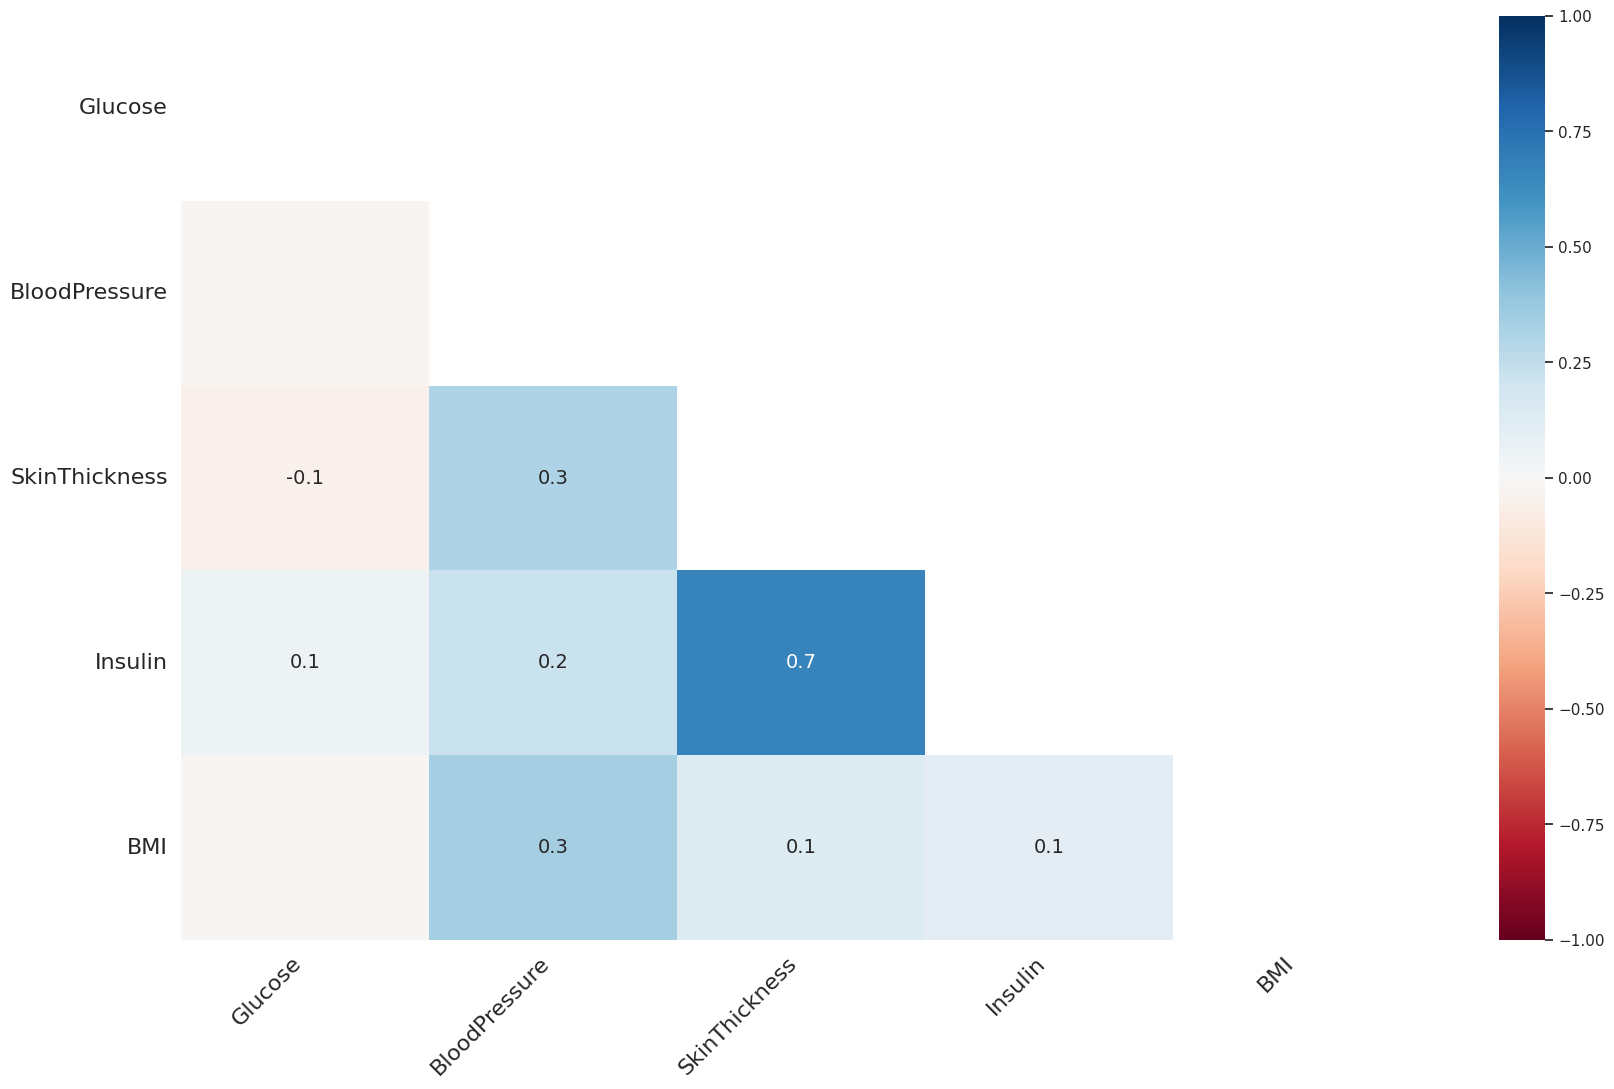

In [ ]:
show_missing_value_plot(df)

In [ ]:
# Examining the Relationship of Missing Values with the Dependent Variable
def missing_vs_target(dataframe, target):
  na_columns = missing_value_table(dataframe, na_name=True)
  temp_df = dataframe.copy()
  for col in na_columns:
    temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)
  na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
  for col in na_flags:
    print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                        "Count": temp_df.groupby(col)[target].count()}))
    print("##################################################")

In [ ]:
missing_vs_target(df, "Outcome")

               n_miss   ratio
Insulin           374 48.7000
SkinThickness     227 29.5600
BloodPressure      35  4.5600
BMI                11  1.4300
Glucose             5  0.6500
                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                     0.3486    763
1                     0.4000      5
##################################################
                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                           0.3438    733
1                           0.4571     35
##################################################
                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                           0.3327    541
1                           0.3877    227
##################################################
                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                     0.3299    394
1                     0.3690    374
###########################################

In [ ]:
def quick_missing_imp(data, target, num_method="meidan", cat_length=20):
  variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]
  temp_target = data[target]

  print("# BEFORE")
  print(data[variables_with_na].isnull().sum(), "\n\n")

  data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)
  if num_method == "mean":
      data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
  elif num_method == "median":
      data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
  data[target] = temp_target

  print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
  print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
  print(data[variables_with_na].isnull().sum(), "\n\n")

  return data

In [ ]:
df = quick_missing_imp(df, "Outcome", num_method="median", cat_length=17)

# BEFORE
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64 




In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Outlier Analysis

In [ ]:
def outlier_thresholds(dataframe,col_name,q1=0.10,q3=0.90):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [ ]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [ ]:
def solve_outliers(dataframe, target):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  for col in num_cols:
    if col!=target:
      print(col, check_outlier(dataframe, col))
      if check_outlier(dataframe, col):
        replace_with_thresholds(dataframe, col)

In [ ]:
solve_outliers(df, "Outcome")

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction True
Age False


In [ ]:
def check_outlier_df(dataframe, target):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  for col in num_cols:
    if col!=target:
      print(col, check_outlier(dataframe, col))

In [ ]:
check_outlier_df(df, "Outcome")

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


# Encoding and Scaling

In [ ]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [ ]:
def label_encoder_dataframe(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"] and dataframe[col].nunique() == 2]
  for col in binary_cols:
    label_encoder(dataframe, col)

In [ ]:
label_encoder_dataframe(df)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31,0
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,1.9490,33,1


In [ ]:
def one_hot_encoding(dataframe, drop_first=True):
  label_encoder_dataframe(dataframe)
  cat_cols = [col for col in dataframe.columns if 10 >= dataframe[col].nunique() > 2]
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
  return dataframe

In [ ]:
df = one_hot_encoding(df)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31,0
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,1.9490,33,1


# Create a Base Model Using All Calssification MLA

In [ ]:
def Create_and_Train_Classification_Models(dataframe, target, test_size=0.20, cv=10, plot=False, save_results=False):
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    results_dict = {'Model_Names': [],
                    'ACC_Train': [],
                    'ACC_Test': [],
                    'ACC_All': [],
                    'R2': [],
                    'R2_Train': [],
                    'R2_Test': [],
                    'CV_Train': [],
                    'CV_Test': [],
                    'CV_All': [],
                    'Accuracy': [],
                    'Precision': [],
                    'Recall': [],
                    'F1-Score': [],
                    'Roc_Auc': []
                    }

    models = [('Logistic', LogisticRegression(solver="liblinear")),
              ("Naive", GaussianNB()),
              ("KNN", KNeighborsClassifier()),
              ("SVC", SVC(kernel="rbf", probability=True)),
              ('CART', DecisionTreeClassifier()),
              ('RF', RandomForestClassifier()),
              ("AdaBoost", AdaBoostClassifier()),
              ('BGTrees', BaggingClassifier(bootstrap_features=True)),
              ('GBM', GradientBoostingClassifier()),
              ("XGBoost", XGBClassifier(objective='reg:squarederror')),
              ("LightGBM", LGBMClassifier(verbose=-1)),
              ("CatBoost", CatBoostClassifier(verbose=False))]

    print("###################### Model Results ######################")

    for name, classifier in models:
        classifier.fit(X_train, y_train)
        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_test)

        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        acc_all = accuracy_score(y, classifier.predict(X))
        r2 = classifier.score(X, y)
        r2_train = classifier.score(X_train, y_train)
        r2_test = classifier.score(X_test, y_test)
        cv_train = cross_val_score(classifier, X_train, y_train, cv=cv).mean()
        cv_test = cross_val_score(classifier, X_test, y_test, cv=cv).mean()
        cv_all = cross_val_score(classifier, X, y, cv=cv).mean()
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

        results_dict['Model_Names'].append(name)
        results_dict['ACC_Train'].append(acc_train)
        results_dict['ACC_Test'].append(acc_test)
        results_dict['ACC_All'].append(acc_all)
        results_dict['R2'].append(r2)
        results_dict['R2_Train'].append(r2_train)
        results_dict['R2_Test'].append(r2_test)
        results_dict['CV_Train'].append(cv_train)
        results_dict['CV_Test'].append(cv_test)
        results_dict['CV_All'].append(cv_all)
        results_dict['Accuracy'].append(cv_results['test_accuracy'].mean())
        results_dict['Precision'].append(cv_results['test_precision'].mean())
        results_dict['Recall'].append(cv_results['test_recall'].mean())
        results_dict['F1-Score'].append(cv_results['test_f1'].mean())
        results_dict['Roc_Auc'].append(cv_results['test_roc_auc'].mean())

        with open(f'{name}_model.pkl', 'wb') as file:
            pickle.dump(classifier, file)

    model_results = pd.DataFrame(results_dict).set_index("Model_Names")
    model_results = model_results.sort_values(by="Accuracy", ascending=False)
    print(model_results)

    if plot:
        plt.figure(figsize=(15, 12))
        sns.barplot(x='Accuracy', y=model_results.index, data=model_results, color="r")
        plt.xlabel('Accuracy Values')
        plt.ylabel('Model Names')
        plt.title('Accuracy for All Models')
        plt.show()

    if save_results:
        model_results.to_csv("model_results.csv")

    return model_results

###################### Model Results ######################
             ACC_Train  ACC_Test  ACC_All     R2  R2_Train  R2_Test  CV_Train  CV_Test  CV_All  Accuracy  Precision  Recall  F1-Score  Roc_Auc
Model_Names                                                                                                                                   
SVC             0.7638    0.7727   0.7656 0.7656    0.7638   0.7727    0.7541   0.7208  0.7644    0.7644     0.7469  0.5040    0.5958   0.8239
Logistic        0.7655    0.7727   0.7669 0.7669    0.7655   0.7727    0.7526   0.7342  0.7631    0.7631     0.7236  0.5373    0.6125   0.8293
GBM             0.9251    0.7987   0.8997 0.8997    0.9251   0.7987    0.7524   0.7208  0.7604    0.7604     0.6917  0.5967    0.6307   0.8272
CatBoost        0.9511    0.8052   0.9219 0.9219    0.9511   0.8052    0.7394   0.7400  0.7604    0.7604     0.6820  0.6081    0.6369   0.8357
RF              1.0000    0.8117   0.9622 0.9622    1.0000   0.8117    0.7474   0.

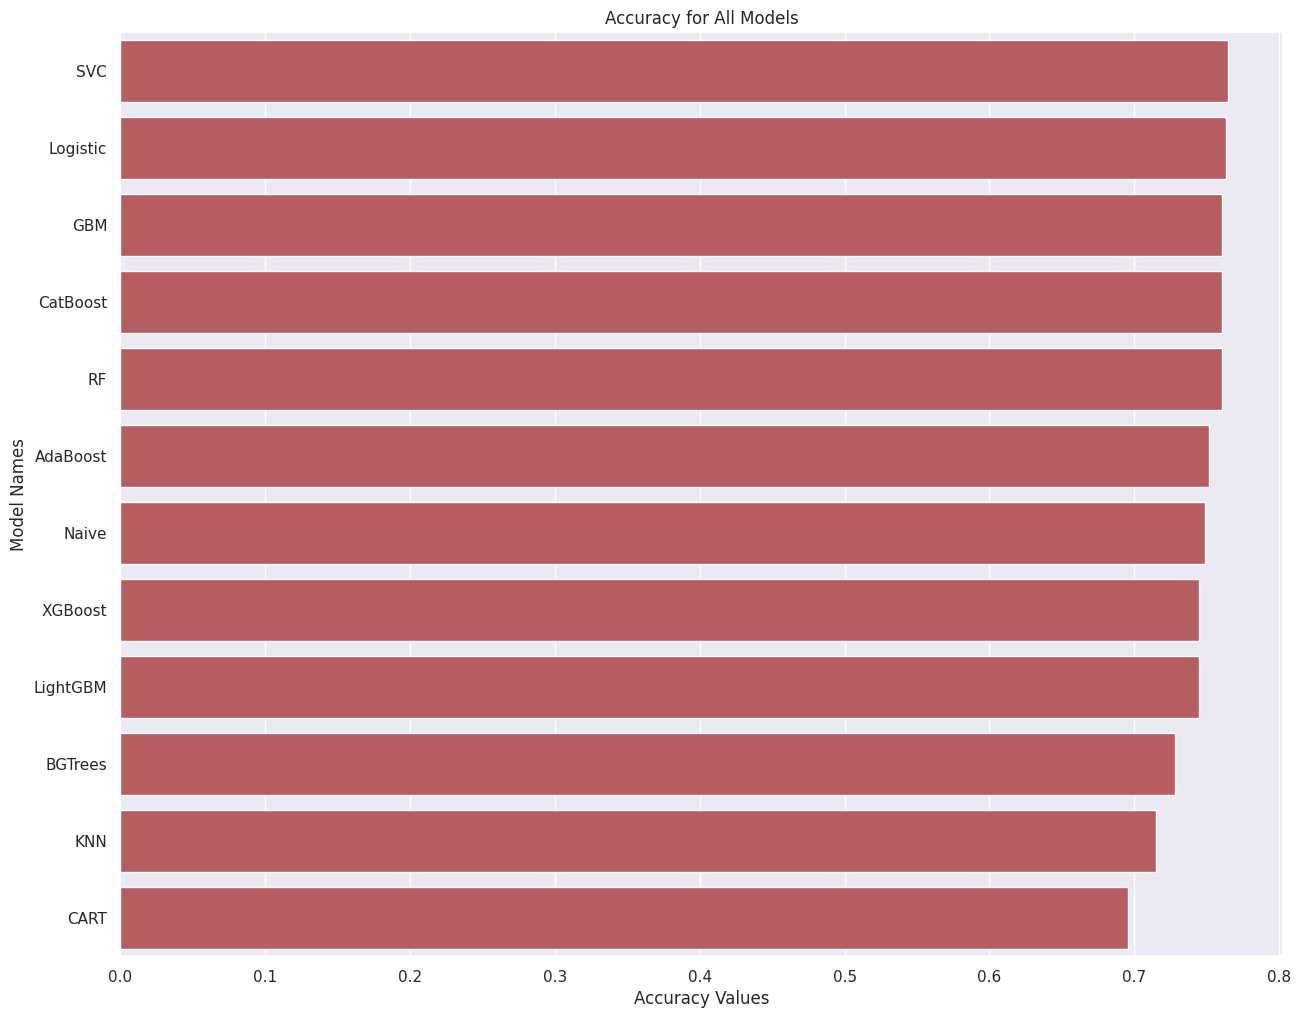

In [ ]:
model_results = Create_and_Train_Classification_Models(df, "Outcome", plot=True, save_results=True)

# Create a Model Tuning Using All Calssification MLA

In [ ]:
def Create_and_Train_Classification_Model_Tuning(dataframe, target, test_size=0.20, cv=10, plot=False, save_results=False):
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    results_dict = {'Model_Names': [],
                    'ACC_Train': [],
                    'ACC_Test': [],
                    'ACC_All': [],
                    'R2': [],
                    'R2_Train': [],
                    'R2_Test': [],
                    'CV_Train': [],
                    'CV_Test': [],
                    'CV_All': [],
                    'Accuracy': [],
                    'Precision': [],
                    'Recall': [],
                    'F1-Score': [],
                    'Roc_Auc': [],
                    'Best_Params': []
                    }
    logistic_params = {}
    naive_params = {}
    knn_params = {"n_neighbors": np.arange(2,50)}
    svc_params = {"C": [0.1,0.01,0.001,1,5,10,20,50,100],
                        "gamma": [0.1,0.01,0.001,1,5,10,20,50,100]}
    cart_params = {"min_samples_split": range(2,100),
                   "max_leaf_nodes": range(2,10)}
    adaboost_params = {"learning_rate": [0.01, 0.1],
                       "n_estimators": [100, 500, 1000]}
    xgboost_params = {"colsample_bytree": [0.4, 0.5 ,0.6],
                      "n_estimators": [200, 500, 1000],
                      "max_depth": [3,5,8],
                      "learning_rate": [0.1, 0.01]}
    rf_params = {"max_depth": [5, 8, 15, None],
                 "max_features": [5, 7, "auto"],
                 "min_samples_split": [8, 15, 20],
                 "n_estimators": [200, 500]}
    gbm_params = {"learning_rate": [0.01, 0.1],
                  "max_depth": [3, 8],
                  "n_estimators": [500, 1000],
                  "subsample": [1, 0.5, 0.7]}
    lightgbm_params = {"learning_rate": [0.01, 0.1],
                       "n_estimators": [300, 500],
                       "colsample_bytree": [0.7, 1]}
    catboost_params = {"iterations": [200, 500],
                       "learning_rate": [0.01, 0.1],
                       "depth": [3, 6]}

    models = [('Logistic', LogisticRegression(solver="liblinear"), logistic_params),
              ("Naive", GaussianNB(), naive_params),
              ("KNN", KNeighborsClassifier(), knn_params),
              ("SVC", SVC(kernel="rbf", probability=True), svc_params),
              ('CART', DecisionTreeClassifier(), cart_params),
              ('RF', RandomForestClassifier(), rf_params),
              ("AdaBoost", AdaBoostClassifier(), adaboost_params),
              ('GBM', GradientBoostingClassifier(), gbm_params),
              ("XGBoost", XGBClassifier(objective='reg:squarederror'), xgboost_params),
              ("LightGBM", LGBMClassifier(verbose=-1), lightgbm_params),
              ("CatBoost", CatBoostClassifier(verbose=False), catboost_params)]

    print("###################### Model Results ######################")

    for name, classifier, params in models:
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X_train, y_train)
        final_model = classifier.set_params(**gs_best.best_params_).fit(X_train, y_train)
        y_train_pred = final_model.predict(X_train)
        y_test_pred = final_model.predict(X_test)

        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        acc_all = accuracy_score(y, final_model.predict(X))
        r2 = final_model.score(X, y)
        r2_train = final_model.score(X_train, y_train)
        r2_test = final_model.score(X_test, y_test)
        cv_train = cross_val_score(final_model, X_train, y_train, cv=cv).mean()
        cv_test = cross_val_score(final_model, X_test, y_test, cv=cv).mean()
        cv_all = cross_val_score(final_model, X, y, cv=cv).mean()
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

        results_dict['Model_Names'].append(name)
        results_dict['ACC_Train'].append(acc_train)
        results_dict['ACC_Test'].append(acc_test)
        results_dict['ACC_All'].append(acc_all)
        results_dict['R2'].append(r2)
        results_dict['R2_Train'].append(r2_train)
        results_dict['R2_Test'].append(r2_test)
        results_dict['CV_Train'].append(cv_train)
        results_dict['CV_Test'].append(cv_test)
        results_dict['CV_All'].append(cv_all)
        results_dict['Accuracy'].append(cv_results['test_accuracy'].mean())
        results_dict['Precision'].append(cv_results['test_precision'].mean())
        results_dict['Recall'].append(cv_results['test_recall'].mean())
        results_dict['F1-Score'].append(cv_results['test_f1'].mean())
        results_dict['Roc_Auc'].append(cv_results['test_roc_auc'].mean())
        results_dict['Best_Params'].append(gs_best.best_params_)

        with open(f'{name}_model.pkl', 'wb') as file:
            pickle.dump(classifier, file)

    model_tuned_results = pd.DataFrame(results_dict).set_index("Model_Names")
    model_tuned_results = model_tuned_results.sort_values(by="Accuracy", ascending=False)
    print(model_tuned_results)

    if plot:
        plt.figure(figsize=(15, 12))
        sns.barplot(x='Accuracy', y=model_tuned_results.index, data=model_tuned_results, color="r")
        plt.xlabel('Accuracy Values')
        plt.ylabel('Model Names')
        plt.title('Accuracy for All Models')
        plt.show()

    if save_results:
        model_tuned_results.to_csv("model_results.csv")

    return model_tuned_results

###################### Model Results ######################
             ACC_Train  ACC_Test  ACC_All     R2  R2_Train  R2_Test  CV_Train  CV_Test  CV_All  Accuracy  Precision  Recall  F1-Score  Roc_Auc                                        Best_Params
Model_Names                                                                                                                                                                                      
XGBoost         0.8290    0.7792   0.8190 0.8190    0.8290   0.7792    0.7605   0.7408  0.7669    0.7669     0.7477  0.5148    0.6029   0.8367  {'colsample_bytree': 0.5, 'learning_rate': 0.0...
Logistic        0.7655    0.7727   0.7669 0.7669    0.7655   0.7727    0.7526   0.7342  0.7631    0.7631     0.7236  0.5373    0.6125   0.8293                                                 {}
CatBoost        0.8127    0.8052   0.8112 0.8112    0.8127   0.8052    0.7589   0.7667  0.7630    0.7630     0.7084  0.5523    0.6160   0.8437  {'depth': 3, 'iterat

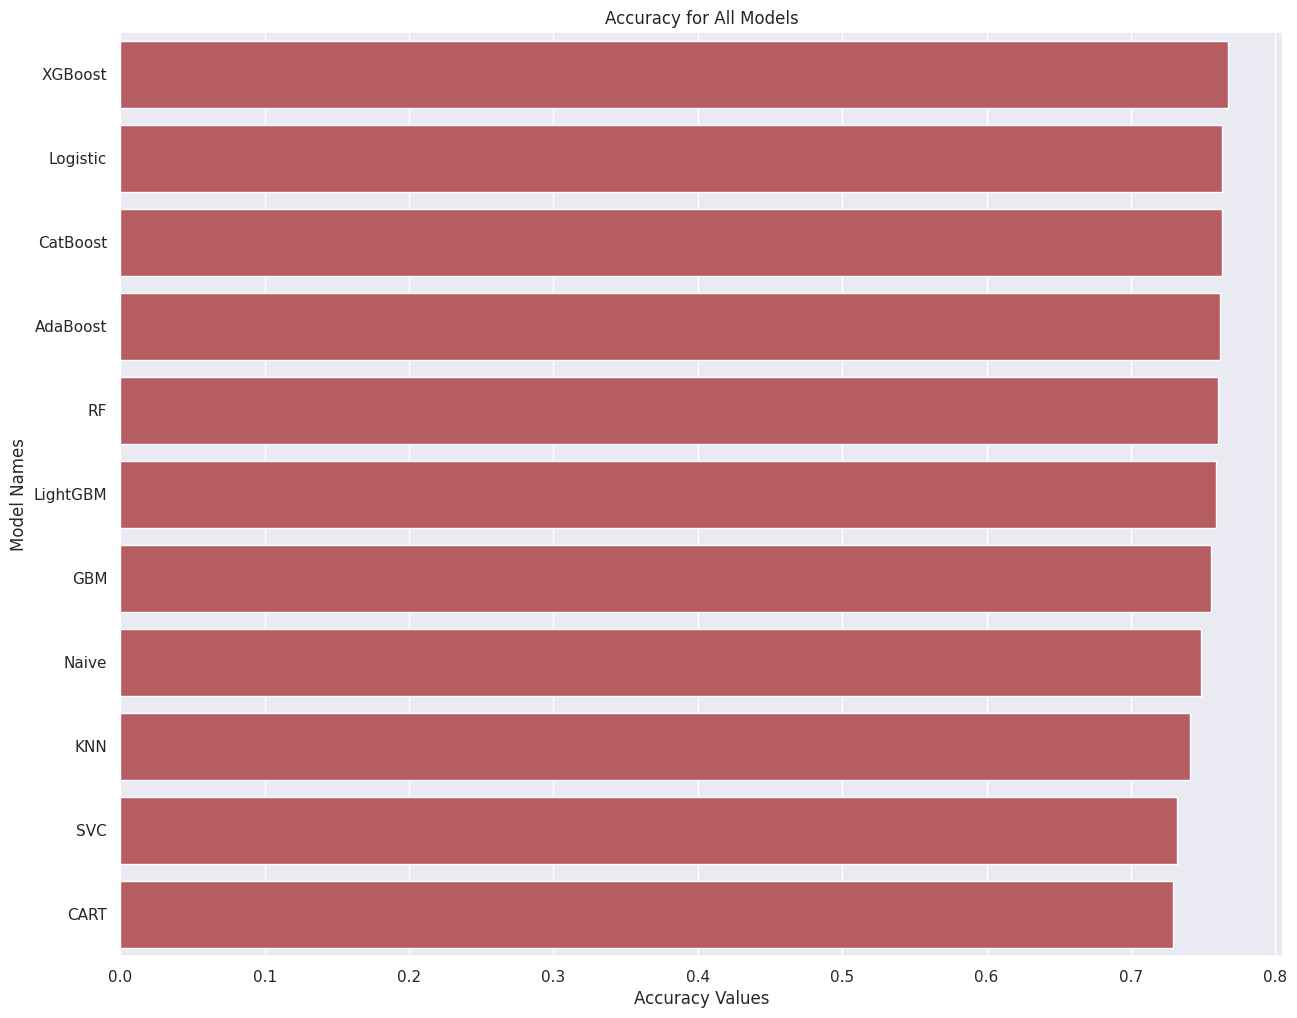

In [ ]:
model_tuned_results = Create_and_Train_Classification_Model_Tuning(df, "Outcome", plot=True, save_results=True)